In [1]:
import numpy as np, sys, json, datetime, multiprocessing
import matplotlib.pyplot as plt
import tikzplotlib as tkz
from tqdm.auto import tqdm

from efficientregressors import GaussianProcessRegressor, DoubleGaussianProcessRegressor
from envs import IndependentPricingEnv, ComplementaryPricingEnv
from utils import generate_curves, generate_user_ranges, generate_graph

In [2]:
class PricingAgentComplementary: 

    
    def __init__(self, num_products, actions, costs, kernel_L, sigma_process, horizon, graph_dict=None, verbose=True):

        self.num_products = num_products
        self.num_actions = len(actions)
        
        self.actions = actions
        self.costs = costs
        
        self.kernel_L = kernel_L
        self.sigma_process = sigma_process
        
        self.horizon = horizon
        self.beta = np.log(self.horizon)
        
        self.interactions_count = 0

        self.total_sales = np.zeros(self.num_products)
        self.total_impressions = np.zeros(self.num_products)

        self.LEAD = "leader"
        self.FOL = "followers"
        self.WITH = "with_leader"
        self.WITHOUT = "without_leader"
        
        self.verbose = verbose
        
        if graph_dict is None:
            self.known_relations = False
            # self.interactions_dataset = -1 * np.ones((num_products, horizon, 2))
        else:
            self.known_relations = True
            self.used_graph_dict = graph_dict
            self._create_regressors()

        if self.verbose:
            print("num products and actions", self.num_products, self.num_actions)
            print("actions", self.actions)
            print("costs", self.costs)
            print("horizon and beta", self.horizon, self.beta)
            print("total sales", self.total_sales)
            print("byvariate_actions", self.byvariate_actions)
            print("byvariate_actions_map", self.byvariate_actions_map)
            print("used_graph_dict", self.used_graph_dict)

    
    def pull(self):

        if self.verbose:
            print("Executing pull(). Interaction count before this: " + str(self.interactions_count))
        
        if self.interactions_count == 0:
            
            self.last_actions_vect = np.zeros(self.num_products, dtype=int)
        
        else:

            self.last_actions_vect = -1 * np.ones(self.num_products, dtype=int)
            
            if self.known_relations:

                if self.verbose:
                    print("Executing pull(). self.used_graph_dict.keys(): " + str(self.used_graph_dict.keys()))
                
                for key in list(self.used_graph_dict.keys()):

                    if self.verbose:
                        print("Executing pull(). running for cicle for key: " + str(key))

                    mu_leader, sigma_leader = self.regressors[key][self.LEAD].compute(self.actions.reshape(self.num_actions, 1))
                    
                    if len(self.used_graph_dict[key]) == 0: 

                        if self.verbose:
                            print("Executing pull(). We have " + str(len(self.used_graph_dict[key])) + "trained products: we use single regressor")
                        
                        self.last_actions_vect[key] = np.argmax(self.actions * (mu_leader + self.beta * sigma_leader))
                        
                    else: 
                        
                        trainee_lst = self.used_graph_dict[key]
                        follower_impressions_vect = np.array([self.total_impressions[trainee_lst[i]] for i in range(len(trainee_lst))])
                        follower_costs_vect = np.array([self.costs[trainee_lst[i]] for i in range(len(trainee_lst))])
                        follower_w_vect = follower_impressions_vect * follower_costs_vect
                        leader_w = self.total_impressions[key] * self.costs[key]

                        if self.verbose:
                            print("Executing pull(). We have " + str(len(self.used_graph_dict[key])) + "trained products: we use double regressor")
                            print("Executing pull(). trainee_lst: " + str(trainee_lst))
                            print("Executing pull(). follower_impressions_vect: " + str(follower_impressions_vect))
                            print("Executing pull(). follower_costs_vect: " + str(follower_costs_vect))
                            print("Executing pull(). follower_w_vect: " + str(follower_w_vect))
                            print("Executing pull(). leader_w: " + str(leader_w))

                        mu_follower_with_leader = np.zeros((len(trainee_lst), self.num_actions))
                        mu_follower_without_leader = np.zeros((len(trainee_lst), self.num_actions))
                        sigma_follower_with_leader = np.zeros((len(trainee_lst), self.num_actions))
                        sigma_follower_without_leader = np.zeros((len(trainee_lst), self.num_actions))
                        
                        for i in range(len(trainee_lst)):
                            mu_follower_with_leader[i, :], sigma_follower_with_leader[i, :] = self.regressors[key][self.FOL][i][self.WITH].compute(self.actions.reshape(self.num_actions, 1))
                            mu_follower_without_leader[i, :], sigma_follower_without_leader[i, :] = self.regressors[key][self.FOL][i][self.WITHOUT].compute(self.actions.reshape(self.num_actions, 1))

                        max_value = 0.0
                        max_idxs = (-1, -1)
                        
                        for action_leader_idx, action_leader_value in enumerate(list(self.actions)):

                            value_leader = leader_w * (mu_leader[action_leader_idx] + self.beta * 
                                                       sigma_leader[action_leader_idx]) * action_leader_value
                            
                            for action_follower_idx, action_follower_value in enumerate(list(self.actions)):

                                value_follower = value_leader

                                for i in range(len(trainee_lst)):
                                    
                                    """value_follower = value_follower + follower_w_vect[i] * (
                                        (mu_follower_with_leader[i, action_follower_idx] + self.beta * 
                                         sigma_follower_with_leader[i, action_follower_idx]) * (mu_leader[action_leader_idx] + self.beta * 
                                         sigma_leader[action_leader_idx]) + 
                                        (mu_follower_without_leader[i, action_follower_idx] + self.beta * 
                                         sigma_follower_without_leader[i, action_follower_idx]) * ((1 - mu_leader[action_leader_idx]) + self.beta * 
                                         sigma_leader[action_leader_idx]) 
                                    ) * action_follower_value"""
                                    value_follower = value_follower + follower_w_vect[i] * (
                                        (mu_follower_with_leader[i, action_follower_idx] + self.beta * 
                                         sigma_follower_with_leader[i, action_follower_idx]) * mu_leader[action_leader_idx] + 
                                        (mu_follower_without_leader[i, action_follower_idx] + self.beta * 
                                         sigma_follower_without_leader[i, action_follower_idx]) * (1 - mu_leader[action_leader_idx]) 
                                    ) * action_follower_value
                                if value_follower >= max_value:
                                    max_value = value_follower
                                    max_idxs = (action_leader_idx, action_follower_idx)
                        
                        self.last_actions_vect[key] = max_idxs[0]
                        for i in range(len(trainee_lst)):
                            self.last_actions_vect[trainee_lst[i]] = max_idxs[1]
                        
            else:
                
                raise NotImplementedError("unknown graph scenario not implemented")     

        if self.verbose:
            print("Executing pull(). Playing: " + str(self.last_actions_vect))
        
        return self.last_actions_vect
            
    
    def update(self, cumul_mx, impressions_mx, sales_mx):
        
        assert cumul_mx.shape == (self.num_products, 2), "update(): error in input"
        assert impressions_mx.ndim == 2, "update(): error in input"
        assert impressions_mx.shape == sales_mx.shape, "update(): error in input"
        assert impressions_mx.shape[0] == self.num_products, "update(): error in input"

        self.total_sales = self.total_sales + cumul_mx[:, 0]
        self.total_impressions = self.total_impressions + cumul_mx[:, 1]
        
        rewards = cumul_mx[:, 0] / cumul_mx[:, 1]
        
        if self.known_relations:
            
            for key in list(self.used_graph_dict.keys()):

                self.regressors[key][self.LEAD].update_data(self.actions[self.last_actions_vect[key]], rewards[key])

                trainee_lst = self.used_graph_dict[key]
                leader_sales = sales_mx[key, :]
                mask_leader_sales = leader_sales == 1
                
                for i, elem in enumerate(trainee_lst): 

                    follower_impressions = impressions_mx[elem, :]
                    follower_sales = sales_mx[elem, :]
                    
                    impressions_without_leader = np.sum(follower_impressions[np.logical_not(mask_leader_sales)])
                    if impressions_without_leader > 0:
                        sales_without_leader = np.sum(follower_sales[np.logical_not(mask_leader_sales)])
                        reward_without_leader = sales_without_leader / impressions_without_leader
                        self.regressors[key][self.FOL][i][self.WITHOUT].update_data(self.actions[self.last_actions_vect[elem]], reward_without_leader)
                        
                    impressions_with_leader = np.sum(follower_impressions[mask_leader_sales])
                    if impressions_with_leader > 0:
                        sales_with_leader = np.sum(follower_sales[mask_leader_sales])
                        reward_with_leader = sales_with_leader / impressions_with_leader
                        self.regressors[key][self.FOL][i][self.WITH].update_data(self.actions[self.last_actions_vect[elem]], reward_with_leader)
        
        else:
            
            self._update_graph_data()

            raise NotImplementedError("unknown graph scenario not implemented")

        self.interactions_count += 1

    
    def _create_regressors(self):

        self.regressors = {}
        
        for key in list(self.used_graph_dict.keys()):
            if len(self.used_graph_dict[key]) == 0: 
                self.regressors[key] = {}
                self.regressors[key][self.LEAD] = GaussianProcessRegressor(self.kernel_L, self.sigma_process, 1)
            else: 
                self.regressors[key] = {}
                self.regressors[key][self.LEAD] = GaussianProcessRegressor(self.kernel_L, self.sigma_process, 1)
                self.regressors[key][self.FOL] = []
                for _ in range(len(self.used_graph_dict[key])):
                    self.regressors[key][self.FOL].append({
                        self.WITH: GaussianProcessRegressor(self.kernel_L, self.sigma_process, 1), 
                        self.WITHOUT: GaussianProcessRegressor(self.kernel_L, self.sigma_process, 1)
                    })
                    
        if self.verbose:
            print("Created regressors: " + str(self.regressors) + " from dict: " + str(self.used_graph_dict))

    
    def _update_graph_data(self):

        raise NotImplementedError("unknown graph scenario not implemented")

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

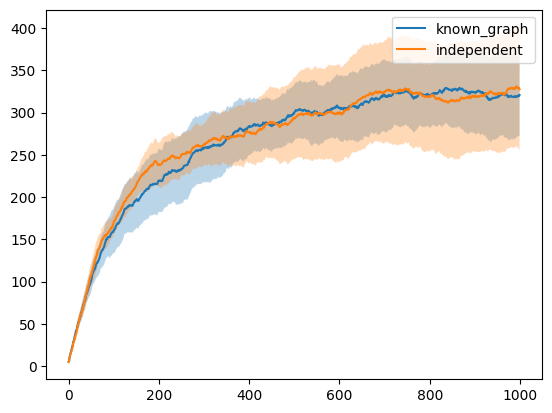

In [3]:
num_actions = 10
num_products = 2
num_clusters = 1
horizon = 1000
min_users = 20
max_users = 30
compl_factor_add = 0.3
compl_factor_molt = 1.4
user_ranges_overall = [min_users, max_users]
sigma_process = 1 / 2 # (2 * np.sqrt(min_users))
actions = np.linspace(0.1, 1.0, num_actions)
costs = np.ones(num_products) # np.random.uniform(1, 2, num_products)
kernel_L = 5
mc_ep = 1000

known_graph = "known_graph"
unknown_graph = "unknown_graph"
independent = "independent"
algs = [known_graph, independent]

num_trials = 10

results_dict = []

for trial_id in range(num_trials):
    
    np.random.seed(trial_id)

    results_dict.append({alg : {"res" : np.zeros((horizon)), "act" : np.zeros((horizon, num_products), dtype=int)} for alg in algs})
    
    demands = generate_curves(num_products, num_actions=num_actions, min_start=0.3, max_start=0.5)
    
    user_ranges = generate_user_ranges(num_products, user_ranges_overall[0], user_ranges_overall[1])
    
    graph_dict = generate_graph(num_products, num_clusters)
    graph_dict_indep = {i: [] for i in range(num_products)}

    for key in graph_dict.keys():
        if len(graph_dict[key]) > 1:
            for i in range(1, len(graph_dict[key])):
                demands[graph_dict[key][i], :] = demands[graph_dict[key][0], :]

    env = ComplementaryPricingEnv(num_products, num_actions, actions, demands, costs, user_ranges, 
                                  graph_dict, compl_factor_add, compl_factor_molt, mc_ep, trial_id)
    optimal_actions, optimal_value = env.compute_optimum()
    
    agent_independent = PricingAgentComplementary(num_products, actions, costs, kernel_L, sigma_process, 
                                      horizon, graph_dict=graph_dict_indep, verbose=False)

    for t in tqdm(range(horizon)):
        results_dict[trial_id][independent]["act"][t, :] = agent_independent.pull()
        cumul_mx, impressions_mx, sales_mx = env.step(results_dict[trial_id][independent]["act"][t, :])
        agent_independent.update(cumul_mx, impressions_mx, sales_mx)
        results_dict[trial_id][independent]["res"][t] = optimal_value
        for i in range(num_products):
            results_dict[trial_id][independent]["res"][t] = results_dict[trial_id][independent]["res"][t] - cumul_mx[i, 0] * actions[results_dict[trial_id][independent]["act"][t, i]]

    agent_known_graph = PricingAgentComplementary(num_products, actions, costs, kernel_L, sigma_process, 
                                      horizon, graph_dict=graph_dict, verbose=False)

    for t in tqdm(range(horizon)):
        results_dict[trial_id][known_graph]["act"][t, :] = agent_known_graph.pull()
        cumul_mx, impressions_mx, sales_mx = env.step(results_dict[trial_id][known_graph]["act"][t, :])
        agent_known_graph.update(cumul_mx, impressions_mx, sales_mx)
        results_dict[trial_id][known_graph]["res"][t] = optimal_value
        for i in range(num_products):
            results_dict[trial_id][known_graph]["res"][t] = results_dict[trial_id][known_graph]["res"][t] - cumul_mx[i, 0] * actions[results_dict[trial_id][known_graph]["act"][t, i]]

plt.figure()
x_plt = np.linspace(0, horizon-1, horizon, dtype=int)
for alg in algs:
    aux = np.zeros((num_trials, horizon))
    for i in range(num_trials):
        aux[i, :] = np.array(results_dict[i][alg]["res"])
    results_alg = np.cumsum(aux, axis=1)
    results_mean = np.mean(results_alg, axis=0)
    results_std = 1.96 * results_alg.std(axis=0) / np.sqrt(num_trials)
    plt.plot(x_plt, results_mean[x_plt], label=alg)
    plt.fill_between(x_plt, results_mean[x_plt] - results_std[x_plt], results_mean[x_plt] + results_std[x_plt], alpha=0.3)
plt.legend()